In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

In [3]:
def show_heatmaps(matrix):
    matrix = matrix.squeeze()
    plt.figure(figsize=(8, 6)) # 移除数组中所有长度为1的维度
    sns.heatmap(matrix,cmap="viridis")
    plt.title("Attention")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.show()


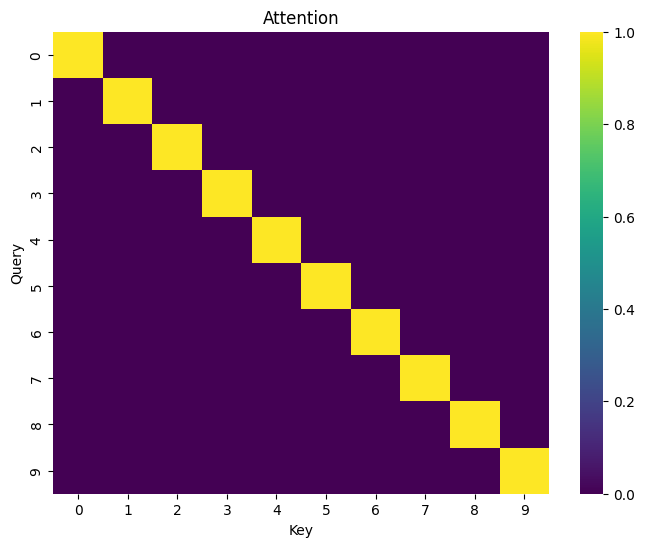

In [4]:
show_heatmaps(torch.eye(10).reshape((1, 1, 10, 10)))

In [5]:
n_train = 50

x_train,_ = torch.sort(torch.rand(n_train) * 5) # rand是0-1
y_train = torch.sin(x_train) * 2 + x_train**0.8
y_train += torch.normal(0,0.5,(n_train,)) # 训练样本添加噪声

n_test = 50
x_test = torch.arange(0, 5, 5/n_test)
y_test = torch.sin(x_test) * 2 + x_test**0.8

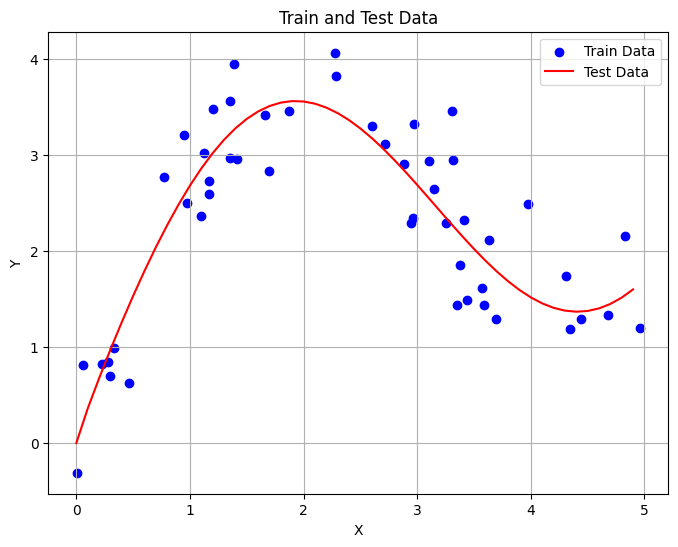

In [6]:
def show_line(y_pred=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(x_train, y_train, color='blue', label='Train Data')
    plt.plot(x_test, y_test, color='red', label='Test Data')
    
    if y_pred is None:
        pass
    else:
        plt.plot(x_test, y_pred, color='green', label='Pred Data')
    plt.title('Train and Test Data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()
show_line()

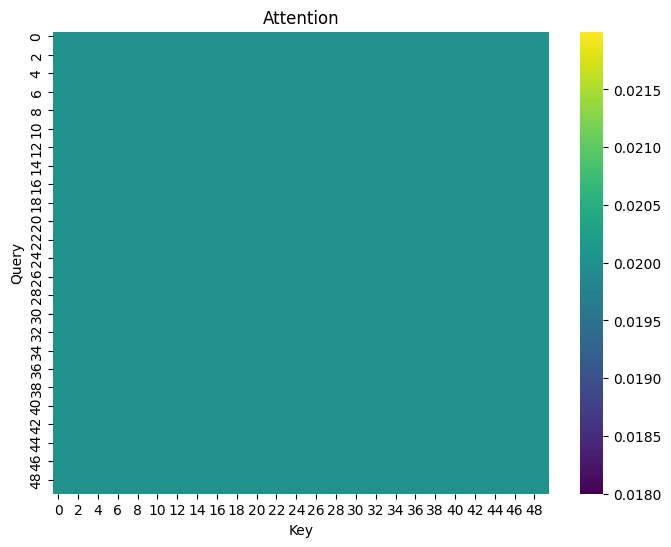

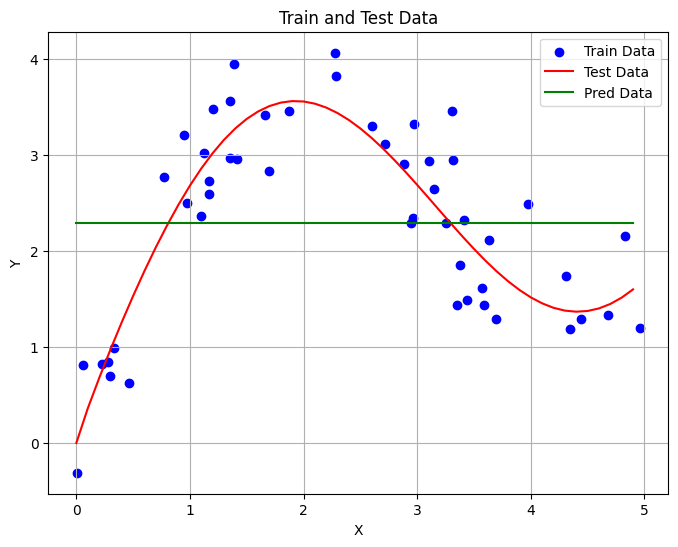

In [7]:
def avg_attention(query, x_train, y_train):
    return torch.full( (len(query), len(x_train)), 1/len(x_train))

attention_weights = avg_attention(x_test, x_train, y_train)
show_heatmaps(attention_weights)

y_pred = torch.matmul(attention_weights, y_train)
show_line(y_pred)


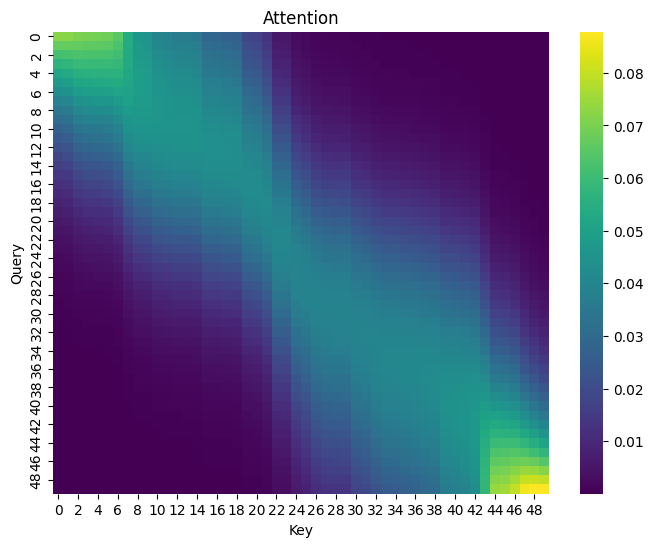

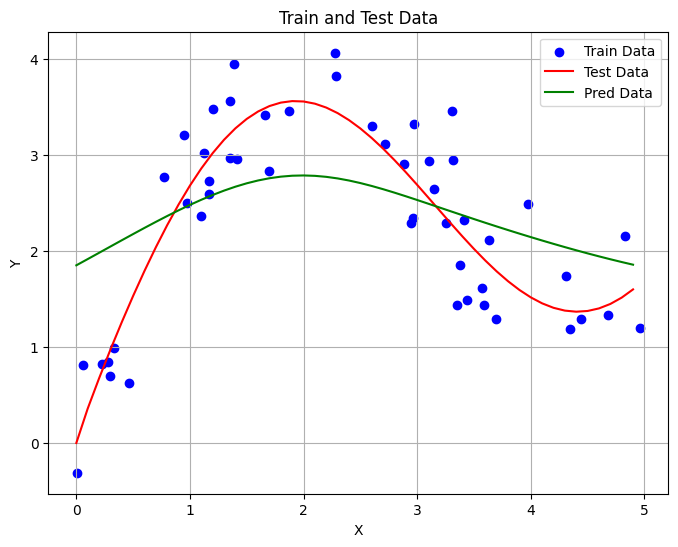

In [8]:
def non_param_attention(query, x_train, y_train):
    x_repeat = x_train.repeat(len(query)).reshape(len(query),-1)
    x_repeat = -1/2 * ((x_repeat - query.reshape(-1,1)) ** 2)
    return nn.functional.softmax(x_repeat, dim=1)

attention_weights = non_param_attention(x_test, x_train, y_train)
show_heatmaps(attention_weights)

y_pred = torch.matmul(attention_weights, y_train)
show_line(y_pred)

In [9]:
class Mynn(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
        self.attention_weights = torch.rand(1,)
        
    def forward(self, query, x_train, y_train):
        x_repeat = (x_train.repeat(len(query)).reshape(len(query),-1) - query.reshape(-1,1)) * self.w
        x_repeat = -1/2 * ( x_repeat** 2)
        self.attention_weights = nn.functional.softmax(x_repeat, dim=1)
        return torch.matmul(self.attention_weights, y_train)

    def getAttention(self):
        show_heatmaps(self.attention_weights)


In [10]:
net = Mynn()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, x_train, y_train), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    

epoch 1, loss 44.137409
epoch 2, loss 5.735574
epoch 3, loss 5.728765
epoch 4, loss 5.721964
epoch 5, loss 5.715167


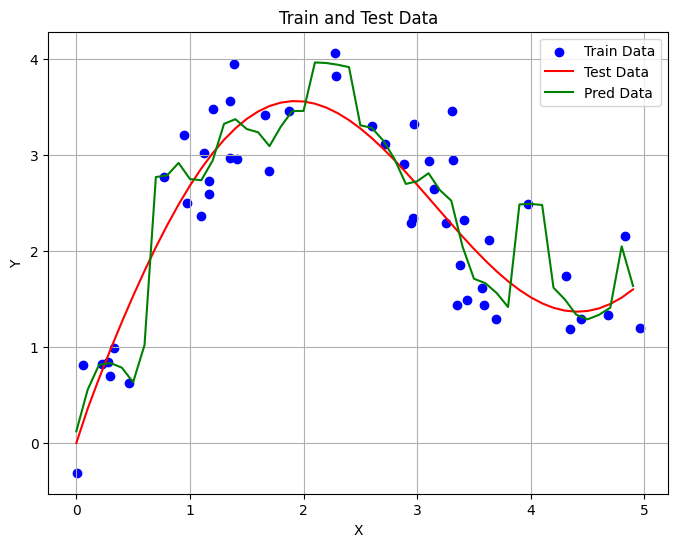

In [11]:
with torch.no_grad():
    y_pred = net(x_test, x_train, y_train)
    show_line(y_pred)

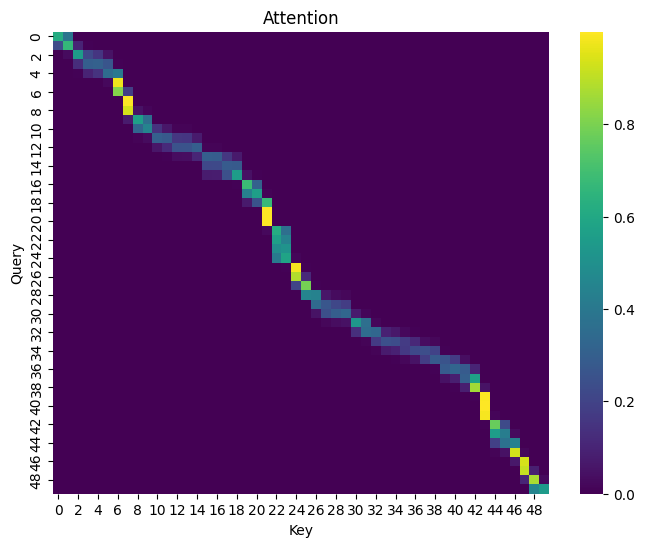

In [12]:
net.getAttention()

In [57]:
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange(maxlen, dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [13]:
#@save
def masked_softmax(X, valid_lens):

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        # 全部变成1d
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1]) #[2,3,..]->[2,2,2,...,3,3,3...]
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [ ]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False) # 注意禁用偏置
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries(batch_size，查询的个数，1，num_hidden)
        # key(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)